# Multi-fidelity BO
Here we demonstrate how Multi-Fidelity Bayesian Optimization can be used to reduce
the computational cost of optimization by using lower fidelity surrogate models. The
goal is to learn functional dependance of the objective on input variables at low
fidelities (which are cheap to compute) and use that information to quickly find the
best objective value at higher fidelities (which are more expensive to compute). This
assumes that there is some learnable correlation between the objective values at
different fidelities.

Xopt implements the MOMF (https://botorch.org/tutorials/Multi_objective_multi_fidelity_BO)
algorithm which can be used to solve both single (this notebook) and multi-objective
(see multi-objective BO section) multi-fidelity problems. Under the hood this
algorithm attempts to solve a multi-objective optimization problem, where one
objective is the function objective and the other is a simple fidelity objective,
weighted by the ```cost_function``` of evaluating the objective at a given fidelity.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 25

import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
import torch

def test_function(input_dict):
    x = input_dict["x"]
    s = input_dict["s"]
    return {"f":np.sin(x + (1.0 - s)) * np.exp((-s+1)/2)}


# define vocs
from xopt import VOCS
vocs = VOCS(
    variables={
        "x": [0, 2*math.pi],
    },
    objectives={"f": "MINIMIZE"},
)

## plot the test function in input + fidelity space


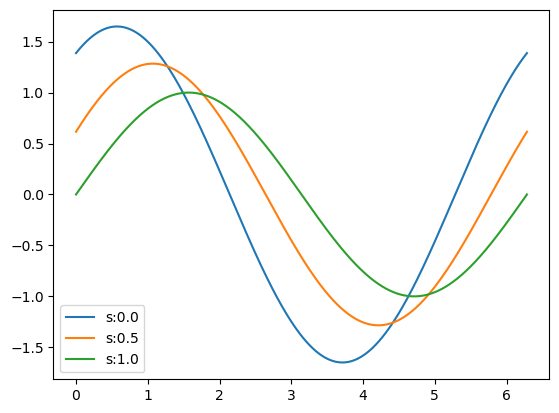

In [2]:
test_x = np.linspace(*vocs.bounds, 1000)
fidelities = [0.0,0.5,1.0]

fig,ax = plt.subplots()
for ele in fidelities:
    f = test_function({"x":test_x, "s":ele})["f"]
    ax.plot(test_x, f,label=f"s:{ele}")

ax.legend()

In [3]:
# create xopt object
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt import Evaluator, Xopt

# get and modify default generator options
options = MultiFidelityGenerator.default_options()

# specify a custom cost function based on the fidelity parameter
options.acq.cost_function = lambda s: s + 0.001

options.optim.num_restarts = NUM_RESTARTS
options.acq.monte_carlo_samples = NUM_MC_SAMPLES

# pass options to the generator
generator = MultiFidelityGenerator(vocs, options=options)
evaluator = Evaluator(function=test_function)

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)
X.generator.options.dict()

{'optim': {'num_restarts': 25,
  'raw_samples': 20,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': None},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

In [4]:
# evaluate initial points at mixed fidelities to seed optimization
X.evaluate_data(pd.DataFrame({
    "x":[math.pi / 4, math.pi / 2., math.pi],"s":[0.0, 0.25, 0.0]
}))

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.00,1.610902,0.000014,False
2,1.570796,0.25,1.064601,0.000004,False
3,3.141593,0.00,-1.387351,0.000002,False


In [5]:
# get the total cost of previous observations based on the cost function
X.generator.calculate_total_cost()

tensor(0.2530, dtype=torch.float64)

In [6]:
# run optimization until the cost budget is exhausted
# we subtract one unit to make sure we don't go over our eval budget
budget = 10
while X.generator.calculate_total_cost() < budget - 1:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")


RuntimeError: n cannot be larger than the number of provided samples

In [ ]:
X.data

## Plot the model prediction and acquisition function inside the optimization space

In [ ]:
# augment the bounds to add the fidelity parameter
bounds = generator.vocs.bounds[::-1]

model = generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = generator.get_acquisition(model)

variable_names = generator.vocs.variable_names
with torch.no_grad():
    print(pts.shape)
    # get the model posterior
    post = model.posterior(pts.unsqueeze(-2))
    f_mean = post.mean[..., 0]
    s_mean = post.mean[..., 1]


    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax0 = plt.subplots()
    c = ax0.pcolor(xx, yy, f_mean.reshape(n, n))
    fig.colorbar(c)
    ax0.set_title("f-Mean prediction")

    fig, ax1 = plt.subplots()
    c = ax1.pcolor(xx, yy, s_mean.reshape(n, n))
    fig.colorbar(c)
    ax1.set_title("s-Mean prediction")

    fig, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax2.set_title("Acquisition function")

    X.data.plot(x=variable_names[0], y=variable_names[1],ax=ax2,style="oC1")

    # mark the next observation
    next_pt = pts[torch.argmax(acq)]
    ax2.plot(*next_pt,"*r",ms=10)

    # mark the optimum at the max fidelity
    best_loc = [1.0, 1.5*np.pi]
    ax2.plot(*best_loc, "*",c="C4")

    for a in [ax0,ax1,ax2]:
        a.set_xlabel(variable_names[0])
        a.set_ylabel(variable_names[1])


## Plot the Pareto front

In [ ]:
X.data.plot(x="f", y="s", style="o-")

In [ ]:
X.data

In [ ]:
# get optimal value at max fidelity, note that the actual maximum is 4.71
X.generator.get_optimum().to_dict()